### This notebook contains Deep Learning and Neural Networks techniques in order to classify X-ray images which were taken from different patients and based on that indicate which respiratory disease the patient has or if he/she does not suffer from any disease at all.


- Neural networks and Deep Learning
    - [tensorflow](https://www.tensorflow.org/)
    - [keras](https://www.keras.io/)

- Data management
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)

- Plotting
    - [seaborn](https://seaborn.pydata.org/)
    - [matplotlib](https://matplotlib.org/)

- Evaluation
  - [scikit-learn](https://scikit-learn.org)



In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [90]:
# Training dataset.
XRAY_Directory = "/content/drive/My Drive/Dataset"

In [91]:
# List directories
# 0 is covid, 1 is normal, 2 is viral pneumonia, 3 is bacterial pneumonia.
os.listdir(XRAY_Directory)

['1', '2', '0', '3']

In [92]:
# Using the ImageDataGenerator to generate image data and normalize it.
# The ImageDataGenerator function is used to load images, normalize them and have them ready for batches.
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [93]:
# 40 images batch.
# The total number of images is 133 * 4 = 532 images.
# Training will use 428 (80%) and validation will use 104 (20%).
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=XRAY_Directory, shuffle=True,
                                                      target_size=(256, 256), class_mode="categorical", subset="training")

Found 428 images belonging to 4 classes.


In [94]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=XRAY_Directory, shuffle=True,
                                                      target_size=(256, 256), class_mode="categorical", subset="validation")

Found 104 images belonging to 4 classes.


In [95]:
# Generate a batch of 40 images and labels.
train_images, train_labels = next(train_generator)

In [96]:
# four-dimensional 40 images of 256 pixels anchy high, colored by the 3 colors.
train_images.shape

(40, 256, 256, 3)

In [97]:
train_labels.shape

(40, 4)

In [98]:
train_labels
# This is according to the position where the 1 indicates the type of disease.

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]],

In [99]:
# Mapping label names.
label_names = {0: 'COVID-19', 1: 'Normal', 2:'Viral Pneumonia', 3:'Bacterial Pneumonia'}

# Dataset visualization

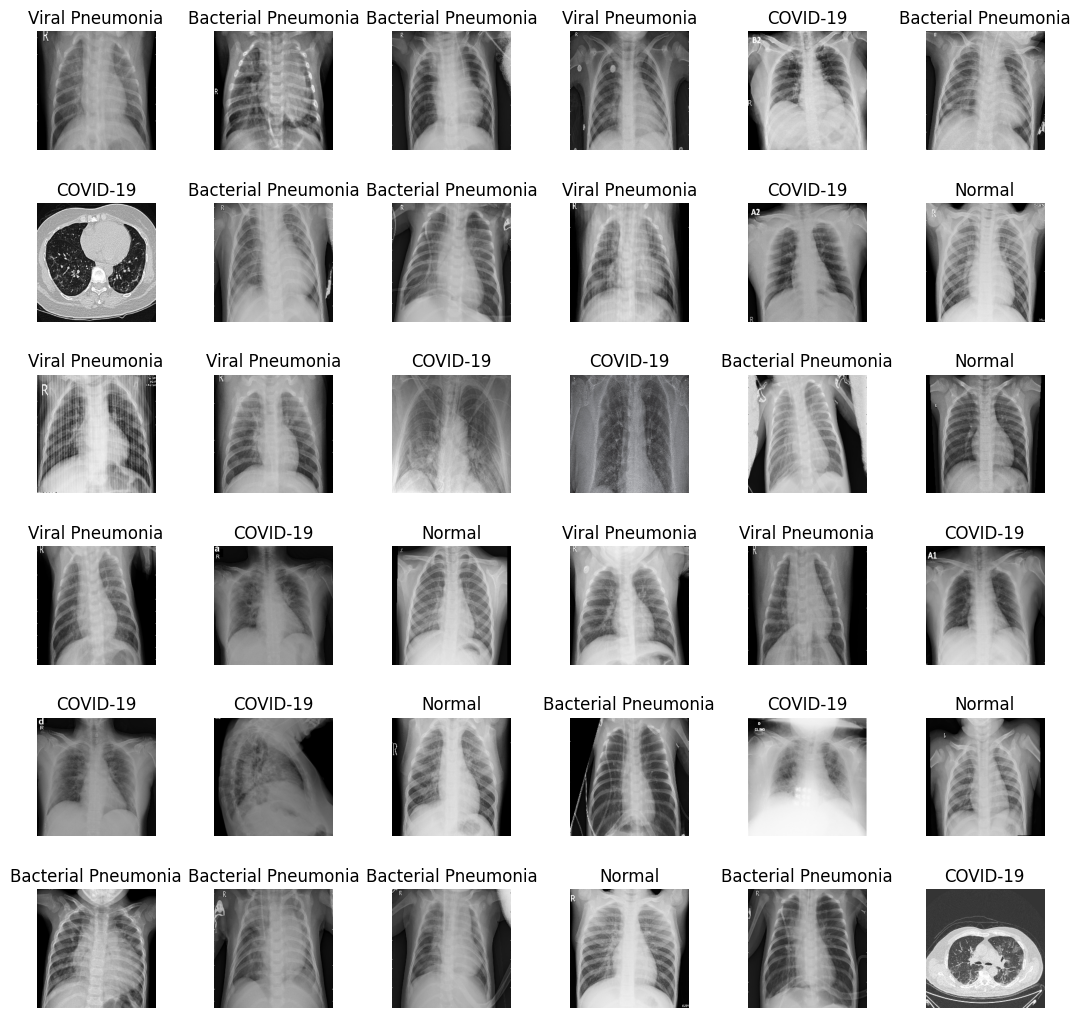

In [ ]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (13,13))
axes = axes.ravel() #  This function returns a 1D array that contains the input elements.

for i in np.arange(0, L*W): # list from 0 to L*W.
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

### Convolutional Neural Networks


*   The first layers of a CNN are used to extract general high-level characteristics.
*   The last layers are used to carry out a clasification task.
*   The respective local fields scan the image for shapes such as lines or edges.



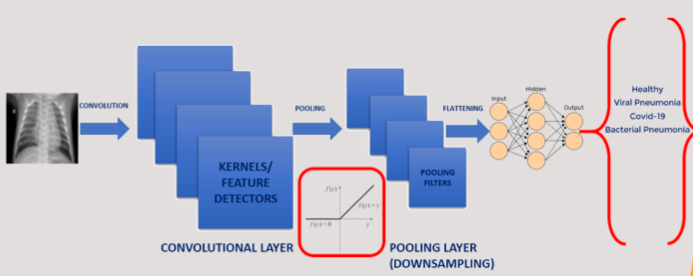

# Import the model with pre-trained weights

#### Residual Network

A Residual Neural Network is a deep learning model in which the weight layers learn residual functions with reference to the layer inputs. A Residual Network is a network with skip connections that perform identity mappings, merged with the layer outputs by addition.

In [100]:
# The input_tensor is the three-dimensional input, i.e. the images of the CT scans.
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256,256,3)))

In [101]:
basemodel.summary()
# ZeroPadding2D is used to fill the edges to start the convolution.

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [102]:
# Freeze the model until the last stages - 4 and carry out retraining.
for layer in basemodel.layers[:-10]:
  layer.trainable = False

# Build and train the Deep Learning model

In [103]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
# The ReLu function removes negative values and leaves the significant ones.
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
# Softmax output layer, there are 4 neurons one for each category of disease.
headmodel = Dense(4, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs= headmodel)

In [104]:
# RMSprop is an innovative stochastic mini-batch learning method.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=1e-6)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate=lr_schedule), metrics = ["accuracy"])

In [105]:
earlystopping = EarlyStopping(monitor= 'val_loss', mode = 'min', verbose= 1, patience = 20) # patience = 20
# Saving the best model with the lowest validation loss.
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose=1, save_best_only= True)

In [106]:
# creating training and validation set with imagegenerator
train_generator = image_generator.flow_from_directory(batch_size=4, directory = XRAY_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory = XRAY_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [107]:
# Training setting.
history= model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs=10,
                             validation_data = val_generator, validation_steps = val_generator.n//4,
                             callbacks= [checkpointer, earlystopping])

Epoch 1/10
106/107 [============================>.] - ETA: 0s - loss: 1.4328 - accuracy: 0.3443
Epoch 1: val_loss improved from inf to 1.42784, saving model to weights.hdf5
107/107 [==============================] - 18s 123ms/step - loss: 1.4299 - accuracy: 0.3458 - val_loss: 1.4278 - val_accuracy: 0.2500
Epoch 2/10
106/107 [============================>.] - ETA: 0s - loss: 1.0710 - accuracy: 0.4929
Epoch 2: val_loss improved from 1.42784 to 1.23548, saving model to weights.hdf5
107/107 [==============================] - 12s 112ms/step - loss: 1.0682 - accuracy: 0.4953 - val_loss: 1.2355 - val_accuracy: 0.3654
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.8900 - accuracy: 0.6192
Epoch 3: val_loss improved from 1.23548 to 0.92311, saving model to weights.hdf5
107/107 [==============================] - 12s 114ms/step - loss: 0.8900 - accuracy: 0.6192 - val_loss: 0.9231 - val_accuracy: 0.5865
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0

# Model evaluation

In [108]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

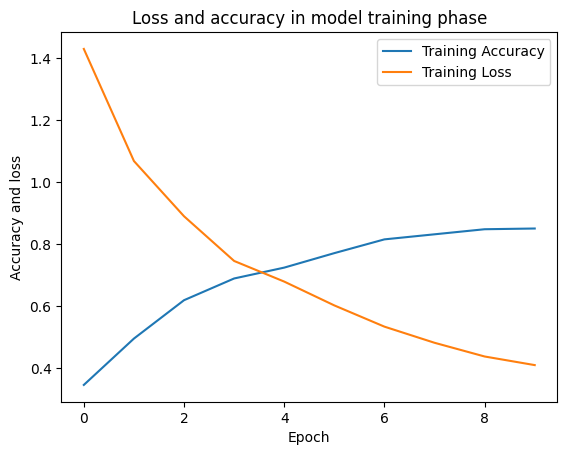

In [109]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title("Loss and accuracy in model training phase")
plt.xlabel("Epoch")
plt.ylabel("Accuracy and loss")
plt.legend(["Training Accuracy", "Training Loss"])

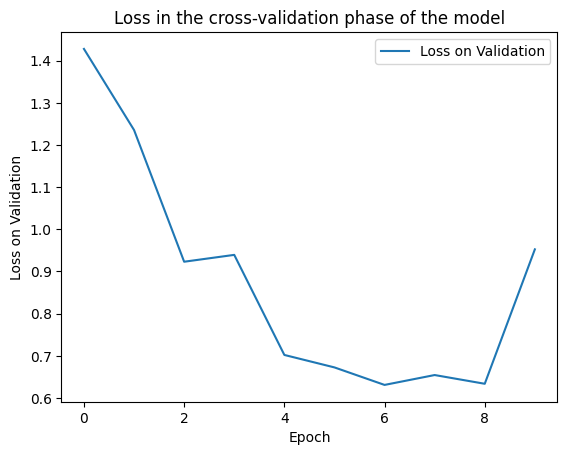

In [110]:
plt.plot(history.history['val_loss'])
plt.title("Loss in the cross-validation phase of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss on Validation")
plt.legend(["Loss on Validation"])

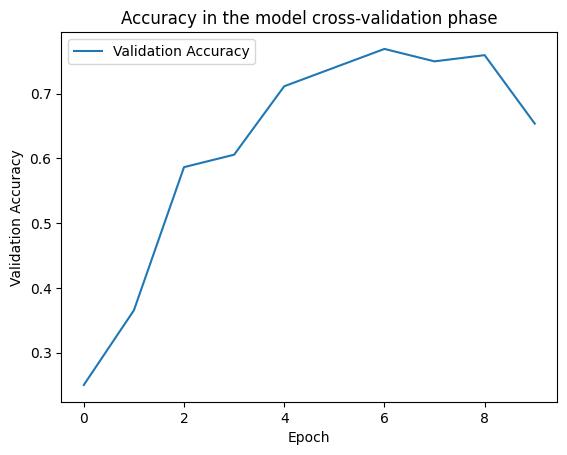

In [111]:
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy in the model cross-validation phase")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(["Validation Accuracy"])

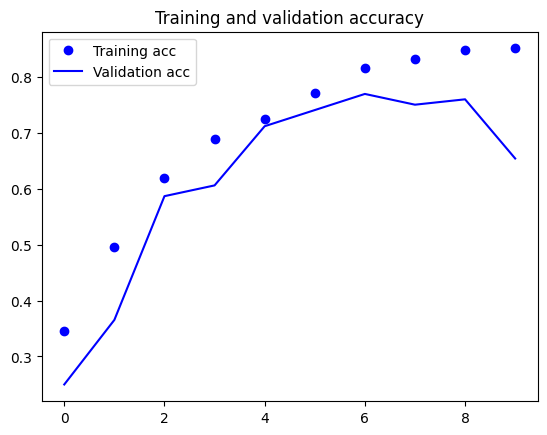

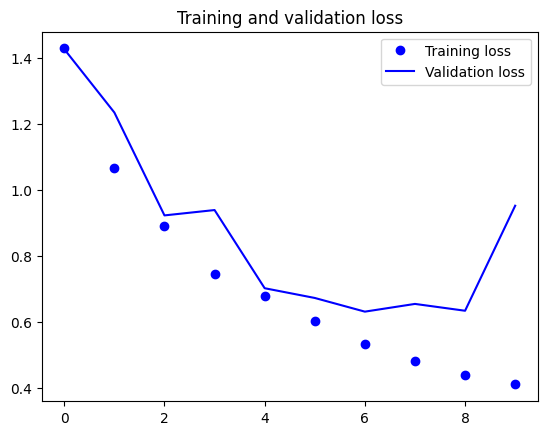

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
test_directory = '/content/drive/MyDrive/Test'
os.listdir(XRAY_Directory)

['1', '2', '0', '3']

In [114]:
test_generator = ImageDataGenerator(rescale=1./255)

In [115]:
# Test set
batch_size=len(test_directory)
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

val_data_gen = test_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_directory, shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 40 images belonging to 4 classes.


In [116]:
# Model evaluation with model.evaluate()
scores = model.evaluate(val_data_gen)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

1/1 [==============================] - 1s 1s/step - loss: 1.0192 - accuracy: 0.6250
evaluate accuracy: 62.50%


In [118]:
# Confussion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = [] 
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img = cv2.imread(os.path.join(test_directory, str(i), item)) # The image is created with the cv2 library
    img = cv2.resize(img, (256, 256)) # Redimension to 256*256, is the expected value
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 25ms/step


In [119]:
len(original)

40

In [120]:
score = accuracy_score(original, prediction)
print("Prediction efficiency {}".format(score))

Prediction efficiency 0.6


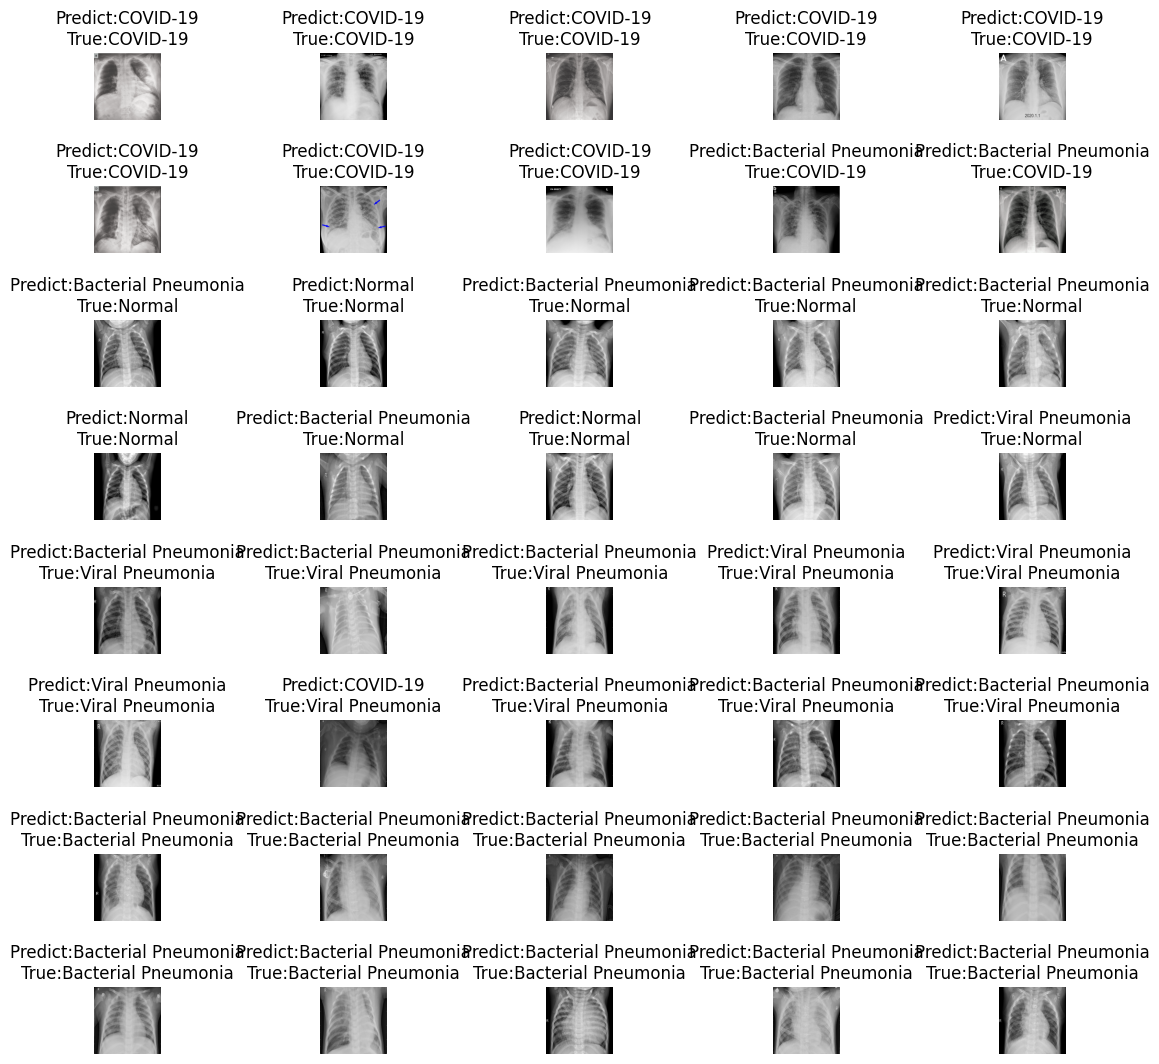

In [121]:
# Test set images
L = 8
W = 5
fig, axes = plt.subplots(L, W, figsize = (13,13))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(image[i])
  axes[i].set_title("Predict:{}\nTrue:{}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace=1.2, hspace=1)

In [122]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.30      0.46        10
           2       0.75      0.30      0.43        10
           3       0.42      1.00      0.59        10

    accuracy                           0.60        40
   macro avg       0.76      0.60      0.58        40
weighted avg       0.76      0.60      0.58        40



Text(0.5, 1.0, 'Matriz de Confusion')

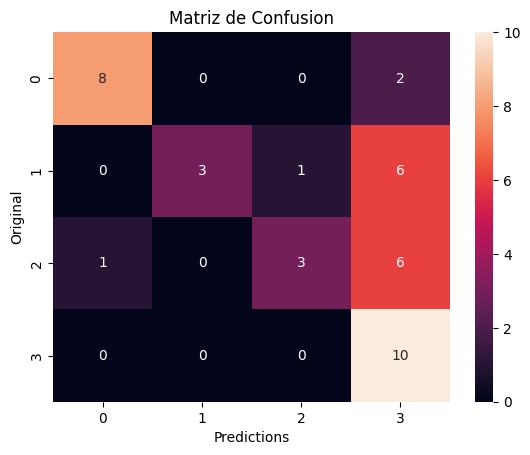

In [123]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel("Predictions")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusion")

+ Categories 1 and 2 (Normal, Viral Pneumonia) were the worst predicted.
+ Category 3 images (Bacterial Pneumonia) are the best predicted, 10 out of 10 correct.
+ Images of categories 1 and 2 (Normal, Viral Pneumonia) have the lowest recall TPR is low.
+ The harmonic mean of precision and recall - F1 Score is low in categories 1 and 2 since their recall is low.